# Cylindrical sky m-mode (1D FFT)

We're looking to evaluate the visibility integral as a function of sidereal angle $\phi$ of the telescope's zenith for a driftscan interferometer. We'll be using a sky gridded with constant RA. and dec. spacings.

The integral is: (irgnoring polarization for now)

$$ \mathcal{V_{i-j}(\nu, \phi)} = \int {\rm d}{\Omega}~A^2(\nu, \alpha, \delta, \phi)~\exp\left[ -2\pi i~\vec{b}_{i-j}\cdot \hat{n}(\alpha, \delta, \phi)/ \lambda(\nu)\right]~I(\nu, \alpha, \delta)$$

We'll assume the primary beams are very simple and only functions of frequency and telescope-local sky coordinates.

Transforming to a sum over a gridded sky in $\alpha_k$, $\delta_l$. We'll also drop $\nu$ accounting as it doesn't factor into the follow.

$$ \mathcal{V_{i-j}(\phi)} = \sum_{k=0}^{N_k-1}\sum_{l=0}^{N_l-1}~\Delta_\alpha~\Delta_\delta~\cos{(\delta_l)}~A^2(\alpha_k, \delta_l, \phi)~\exp\left[ -2\pi i~\vec{b}_{i-j}\cdot \hat{n}(\alpha_k, \delta_l, \phi)/ \lambda\right]~I(\alpha_k, \delta_l)$$

For a driftscan telescope, $\hat{n}$ only cares about coordinates relative to the telescope's zenith and $A^2$ only cares about coordinates relative to the telescope's fixed pointing (which could also just be its zenith). What this means is that, $A^2(\alpha_k, \delta_l, \phi) = A^2(\alpha_k+\phi, \delta_l)$ and $\hat{n}(\alpha_k, \delta_l, \phi) = \hat{n}(\alpha_k+\phi, \delta_l)$.

Collecting terms and defining a real-space beam transfer matrix $B$:

$$ \mathcal{V_{i-j}(\phi)} = \sum_{k=0}^{N_k-1}\sum_{l=0}^{N_l-1}~B_{i-j}(\alpha_k+\phi, \delta_l)~I(\alpha_k, \delta_l)$$

Rewriting in terms of the $\alpha_k$ direction discrete Fourier transforms with numpy conventions, conjugate transforming the BTM:

$$B_{i-j}(\alpha_k+\phi, \delta_l) = \sum_m \tilde{B}_{i-j,\phi=0}(m, \delta_l) \exp\left[-im\alpha_k\right]\exp\left[-im\phi\right]$$

$$I(\alpha_k, \delta_l) = \frac{1}{N_k}\sum_{m^\prime} \tilde{I}(m^\prime, \delta_l) \exp\left[im^\prime\alpha_k\right] $$

For $m = 2\pi k/N_k$ for $k=0,...,N_k-1$. Under the DFT orthogonality, we have:

$$\sum_{k=0}^{N_k-1} \exp{\left[i(m^\prime - m)\alpha_k\right]} = N_k \delta_{m m^\prime}$$

so we can kill the $\alpha_k$ component of the visibility sum and have:

$$ \mathcal{V_{i-j}(\phi)} = \sum_m\sum_{l=0}^{N_l-1}~\tilde{B}_{i-j,\phi=0}(m, \delta_l)~\tilde{I}(m, \delta_l)\exp\left[-im\phi\right]$$

It is then immediately obvious that if we define the DFT of $\mathcal{V_{i-j}(\phi)}$ along the $\phi$ direction, as:

$$ \mathcal{V}_{i-j}(\phi) = \sum_m \tilde{\mathcal{V}}_{i-j}(m)\exp\left[-im\phi\right]$$

that,

$$\tilde{\mathcal{V}}_{i-j}(m) = \sum_{l=0}^{N_l-1}~\tilde{B}_{i-j,\phi=0}(m, \delta_l)~\tilde{I}(m, \delta_l)$$

That is, you can write this projection separably as a matrix multiply on the $\delta_l$'s for each $m$, $\nu$ and baseline index ($i-j$), yielding the $m$-mode visibilities.

To do this you just need to pre-compute, $\tilde{B}(m, \delta_l, \phi=0, \nu, i-j)$ and $\tilde{I}(m, \delta_l, \nu)$, being explicit about all DoF (except polarisation) now.

Using the numpy DFT convention: (all DFTs along $\alpha_k$ axis)

$$\tilde{B}(m, \delta_l, \phi=0, \nu, i-j) = \mathrm{iDFT}\left[ \Delta_\alpha~\Delta_\delta~\cos{(\delta_l)}~A^2(\nu, \alpha_k, \delta_l, \phi=0)~\exp\left[ -2\pi i~\vec{b}_{i-j}\cdot \hat{n}(\alpha_k, \delta_l, \phi=0)/ \lambda(\nu)\right] \right],$$

$$\tilde{I}(m, \delta_l, \nu) = \mathrm{DFT}\left[I(\nu, \alpha, \delta)\right]$$
and, to recover the TOD visibilities:
$$\mathcal{V}(\nu, i-j, \phi) = \mathrm{iDFT}\left[\tilde{\mathcal{V}}(\nu, m, i-j)\right]$$

In [3]:
import os

import numpy as np
import h5py
from scipy.special import j1 as bessel_j1
import matplotlib.pyplot as plt

from astropy import units
from astropy import coordinates as coords
import healpy as hp
import dask.array as da

NA = np.newaxis

In [4]:
def airy_beam(separations, frequency, diameter=6, voltage=False):

    seps = units.Quantity(separations, unit=units.degree)
    diameter = units.Quantity(diameter, unit=units.m)
    freq = units.Quantity(frequency, unit=units.MHz)
    lamb = freq.to('m', equivalencies=units.spectral())

    x = np.pi*diameter/lamb*np.sin(seps.to('radian').value)
    out = (2*bessel_j1(x)/x)  # (Voltage Beam)

    if voltage:
        return out
    else:
        return out**2

In [5]:
freq_edges = np.linspace(500, 600, 128+1)
freqs = freq_edges[:-1] + np.diff(freq_edges[:2])[0]/2
wavelengths = (freqs*units.MHz).to('m', equivalencies=units.spectral()).value
pols = ['XX', 'YX', 'XY', 'YY']
baselines = np.array(
    [[  0. ,   8.5, 0],
     [  0. ,  17. , 0],
     [  6.5, -17. , 0],
     [  6.5,  -8.5, 0],
     [  6.5,   0. , 0],
     [  6.5,   8.5, 0],
     [  6.5,  17. , 0],
     [ 13. , -17. , 0],
     [ 13. ,  -8.5, 0],
     [ 13. ,   0. , 0],
     [ 13. ,   8.5, 0],
     [ 13. ,  17. , 0],
     [ 19.5,  -8.5, 0],
     [ 19.5,   0. , 0],
     [ 19.5,   8.5, 0]
     ]
     ) # in ENU metres

In [6]:
N_ra = 1024
N_dec = 128
declination_center = coords.Latitude(-30, unit=units.degree)
declination_span = coords.Angle(30, unit=units.degree)

right_ascension = coords.Longitude(
            np.linspace(180, -180, N_ra + 1)[1:] * units.deg,
            wrap_angle=180 * units.deg,
        )

declination = coords.Latitude(
            np.linspace(
                -declination_span / 2 + declination_center,
                declination_span / 2 + declination_center,
                N_dec,
            )
        )

healpix_theta = np.pi / 2 - declination.rad
healpix_phi = right_ascension.wrap_at(360*units.deg).rad

# Right ascension in descending order
delta_ra = right_ascension[0] - right_ascension[1]
delta_dec = declination[1] - declination[0]
delta_lon_physical = delta_ra * np.cos(declination.rad)
print(f"Resolution: R.A.:{delta_lon_physical[N_dec//2]:.3f}, Decl.:{delta_dec:.3f}")
pixel_solid_angle = delta_lon_physical*delta_dec

sky_coordinates = coords.SkyCoord(ra=right_ascension[:, NA], dec=declination[NA, :])

local_origin = coords.SkyCoord(ra=0 * units.deg, dec=declination_center)
local_origin_offset_frame = coords.SkyOffsetFrame(origin=local_origin)

offset_coordinates = sky_coordinates.transform_to(local_origin_offset_frame)
enu_unit_vectors = offset_coordinates.cartesian.xyz[(1, 2, 0), :].value

Resolution: R.A.:0.305 deg, Decl.:0.236 deg


In [7]:
# Make BTM array:
# BTM: m, baseline (ignore pol.), nu, decl.
ch_m, ch_bl, ch_nu, ch_decl = N_ra, 3, 32, 32
da_seps = da.from_array(sky_coordinates.separation(local_origin).value, chunks=(ch_m, ch_decl))
da_freqs = da.from_array(freqs, chunks=(ch_nu,))
primary_beam = da.map_blocks(airy_beam, da_seps[:, NA, :], da_freqs[NA, :, NA]) * pixel_solid_angle[NA, NA, :].value
da_enu_unit_vectors = da.from_array(enu_unit_vectors, chunks=(3, ch_m, ch_decl))
da_baselines = da.from_array(baselines.T, chunks=(3, ch_bl))
phase = -2j * np.pi * da.sum(da_enu_unit_vectors[..., NA, :] * da_baselines[:, NA, :, NA], axis=0)
rs_btm = primary_beam[:, NA, ...] * da.exp(phase[..., NA, :]/wavelengths[NA, NA, :, NA])
btm = da.fft.ifft(rs_btm, axis=0)

In [11]:
#if os.path.exists('data/cached_products.h5'):
    #os.remove('data/cached_products.h5')
da.to_hdf5('./data/cached_products.h5', '/btm', btm)

In [13]:
fil_btm = h5py.File('data/cached_products.h5', 'r')
btm = da.from_array(fil_btm['btm'], chunks=(1, -1, -1, -1))
btm

,Array,Chunk
Bytes,3.75 GiB,3.75 MiB
Shape,"(1024, 15, 128, 128)","(1, 15, 128, 128)"
Count,1025 Tasks,1024 Chunks
Type,complex128,numpy.ndarray


In [14]:
gal_map = h5py.File('/home/devin/data/2110_ml_visibilities/coragalaxy_1.h5', 'r')
nside = hp.npix2nside(gal_map['map'].shape[-1])
projected_map = np.empty((4, N_ra, len(freqs), N_dec))
pix, weights = hp.get_interp_weights(nside, healpix_theta[NA, :], healpix_phi[:, NA])
for ipol in range(4):
    for ifreq in range(128):
        pixels = gal_map['map'][ifreq, ipol, :][..., np.ravel(pix)].reshape(pix.shape)
        projected_map[ipol,:,ifreq,:] = np.sum(pixels*weights, axis=0)
projected_map = da.from_array(projected_map)

if os.path.exists('data/cached_gal_map.h5'):
    os.remove('data/cached_gal_map.h5')
da.to_hdf5('data/cached_gal_map.h5', '/rs_map', projected_map)

fil_gal_map = h5py.File('data/cached_gal_map.h5', 'r+')
projected_map = da.from_array(fil_gal_map['rs_map']).rechunk({1:N_ra})

OSError: Unable to open file (unable to open file: name = '/home/devin/data/2110_ml_visibilities/coragalaxy_1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [14]:
fs_projected_map = da.fft.fft(da.fft.fftshift(projected_map, axes=1), axis=1)
#fs_projected_map
da.to_hdf5('data/cached_gal_map.h5', '/fs_map', fs_projected_map)

In [15]:
fs_gal_map = da.from_array(fil_gal_map['fs_map'], chunks=(-1, 1, -1, -1))
fs_gal_map

,Array,Chunk
Bytes,1.00 GiB,1.00 MiB
Shape,"(4, 1024, 128, 128)","(4, 1, 128, 128)"
Count,1025 Tasks,1024 Chunks
Type,complex128,numpy.ndarray


In [16]:
mmodes = da.sum(btm*fs_gal_map[0][:, NA, ...], axis=-1)
mmodes

dask.array<sum-aggregate, shape=(1024, 15, 128), dtype=complex128, chunksize=(1, 15, 128), chunktype=numpy.ndarray>

In [17]:
mmodes = mmodes.rechunk({0:N_ra})
visibilities = da.fft.ifft(mmodes, axis=0).persist()

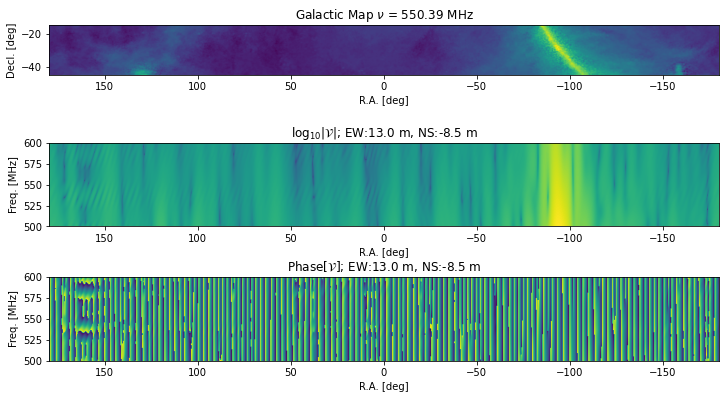

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(12, 7))

ifreq = 64
ibase = 8
baseline_tag = f'EW:{baselines[ibase, 0]} m, NS:{baselines[ibase, 1]} m'

rs_gal_map = da.from_array(fil_gal_map['rs_map'])
extent = (right_ascension[0].value, right_ascension[-1].value, 
          declination[0].value, declination[-1].value)
axs[0].imshow(np.log10(rs_gal_map[0, :, ifreq, :].compute().T), origin='lower', extent=extent,
              aspect=0.9)
axs[0].set_title(r'Galactic Map $\nu$ = {:.2f} MHz'.format(freqs[ifreq]))
axs[0].set_ylabel('Decl. [deg]')

extent = (right_ascension[0].value, right_ascension[-1].value, 
          freq_edges[0], freq_edges[-1])

aspect = 0.45

axs[1].imshow(np.log10(np.abs(visibilities[:, ibase, :]).T), extent=extent, origin='lower', aspect=aspect)
axs[1].set_title(r'$\log_{10}|\mathcal{V}|$; ' + baseline_tag)
axs[2].imshow(np.angle(visibilities[:, ibase, :]).T, extent=extent, origin='lower', aspect=aspect)
axs[2].set_title(r'Phase[$\mathcal{V}$]; ' + baseline_tag)

for ax in axs[1:]:
    ax.set_ylabel('Freq. [MHz]')

for ax in axs:
    ax.set_xlabel('R.A. [deg]')